In [1]:
import pandas as pd
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
data = pd.read_excel("C:\\Users\\SSP\\Desktop\\Dr_Baradaran\\spf.data.xlsx",header=2)
data.head()

,seg,Y,X1,X2,X3,X4,Unnamed: 6
0,59,49,4.344300,8076.666667,0.920747,4,1
1,58,44,9.025771,8076.666667,0.553969,5,2
2,57,35,9.401453,8076.666667,0.106367,1,3
3,56,1,0.685524,8076.666667,0.000000,0,4
4,55,5,1.494137,8076.666667,0.000000,0,5


In [3]:
#STEP1: fitting the Poisson regression model

expr = """Y ~ X1  + X2 + X3"""
y, X = dmatrices(expr, data, return_type='dataframe')

In [4]:
poisson_training_results = sm.GLM(y, X, family=sm.families.Poisson()).fit()
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                   59
Model:                            GLM   Df Residuals:                       55
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -245.95
Date:                Mon, 20 Jun 2022   Deviance:                       254.63
Time:                        20:06:31   Pearson chi2:                     266.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.9961
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.2476      0.780      5.444      0.0

In [5]:
print(poisson_training_results.mu)
print(len(poisson_training_results.mu))

[13.36062859 37.28995131 38.85169061  5.31621739  6.38731073  8.72546845
  5.32854092  6.29002033  8.33438161  9.91947923  6.545644    7.84843888
 25.56415015  6.72150783  7.85668845 18.66260826 12.52039594 32.38823492
 43.84603708 10.64460884 11.687831   28.38896959 27.8502436  24.09449681
  8.18799293 11.10504495  9.4866596  10.3479221   6.62017752  9.31213262
  8.41812668 10.46386326  7.93258919  8.2928592  10.2524749   6.75565228
  8.56603812  9.23146771  8.50952346  8.88640723 14.54896533 22.90559728
 17.25040427 39.25294105  8.67652551  6.92552495 29.00330913  9.07030364
 21.28905197  8.28421437  9.91708174 33.02891818 11.42257342  6.93636556
 14.30824687 11.11390997 14.85399023 14.29817883 22.12142147]
59


In [6]:
#STEP 2: The determination of α

import statsmodels.formula.api as smf

In [7]:
data['Y_LAMBDA'] = poisson_training_results.mu

In [8]:
data['AUX_OLS_DEP'] = data.apply(lambda x: ((x['Y'] - x['Y_LAMBDA'])**2 - x['Y_LAMBDA']) / x['Y_LAMBDA'], axis=1)

In [9]:
ols_expr = """AUX_OLS_DEP ~ Y_LAMBDA - 1"""

In [10]:
aux_olsr_results = smf.ols(ols_expr, data).fit()

In [16]:
print(aux_olsr_results.params)

Y_LAMBDA    0.133967
dtype: float64


In [17]:
aux_olsr_results.tvalues

Y_LAMBDA    1.404661
dtype: float64

In [18]:
print("Critical t-value at a 99% confidence level (right-tailed), and degrees of freedom=59 is 2.391229")
print("which is not comfortably less than the t-statistic of alpha (1.404661)")
print("So α=0.133967 is NOT statistically significant")
print("Therefore, the Negative Binomial regression model cannot do a better job of fitting the training data set than a Poisson regression model.")

Critical t-value at a 99% confidence level (right-tailed), and degrees of freedom=59 is 2.391229
which is not comfortably less than the t-statistic of alpha (1.404661)
So α=0.133967 is NOT statistically significant
Therefore, the Negative Binomial regression model cannot do a better job of fitting the training data set than a Poisson regression model.


In [19]:
#STEP 3: Train the NB2 on the data using the alpha found in the previous step

nb2_training_results = sm.GLM(y, X,family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()

In [20]:
print(nb2_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                   59
Model:                            GLM   Df Residuals:                       55
Model Family:        NegativeBinomial   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -202.20
Date:                Mon, 20 Jun 2022   Deviance:                       110.79
Time:                        20:15:42   Pearson chi2:                     108.
No. Iterations:                     7   Pseudo R-squ. (CS):             0.8473
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.3921      1.438      3.053      0.0

In [21]:
#STEP 4:  Make some predictions

nb2_predictions = nb2_training_results.get_prediction(X)

In [22]:
predictions_summary_frame = nb2_predictions.summary_frame()
print(predictions_summary_frame)

         mean   mean_se  mean_ci_lower  mean_ci_upper
0   13.231448  1.754876      10.202655      17.159377
1   39.946011  6.485070      29.059248      54.911393
2   41.892726  6.550870      30.834301      56.917147
3    4.955081  0.752578       3.679343       6.673156
4    6.034475  0.843642       4.588158       7.936712
5    8.410575  1.003597       6.656646      10.626637
6    4.967415  0.753648       3.689670       6.687648
7    5.935843  0.835484       4.504782       7.821516
8    8.004481  0.971023       6.310648      10.152954
9    9.657340  1.110042       7.709355      12.097539
10   6.195229  0.856898       4.724141       8.124412
11   7.501383  0.932621       5.879148       9.571243
12  26.750458  3.477891      20.733111      34.514212
13   6.374118  0.871602       4.875579       8.333243
14   7.536790  0.966997       5.861033       9.691670
15  19.056605  2.210688      15.181011      23.921608
16  12.430144  1.415879       9.943024      15.539386
17  34.391199  5.042340     

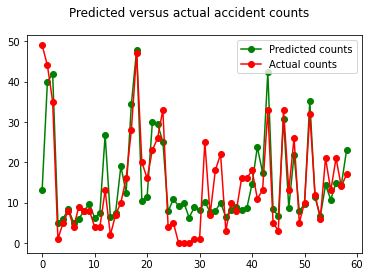

In [23]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y['Y']
fig = plt.figure()
fig.suptitle('Predicted versus actual accident counts')
predicted, = plt.plot(X.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

In [24]:
#STEP 5: Measuring the goodness-of-fit of the NB2 model

#Log-Likelihood: Likelihood-ratio (LR) test - negative two times the difference in the fitted log-likelihoods of the two models
LR = 2*(245.95-202.20)
print("LR test value =", LR)
print("χ2(1) = 6.635") # critical value of χ2(1) at the 1% significance level

LR test value = 87.5
χ2(1) = 6.635


In [25]:
#The Deviance and Pearson chi-squared statistics
NB_Deviance = 110.79
NB_Pearson_chi2 = 108

Chi_Squared_0_05 = 77.931
print("Deviance and Pearson chi-squared for the NB2 model are greater than the standard Chi-Squared value at p=0.05 and DF=59")
print("We might be able to do better!!")

Deviance and Pearson chi-squared for the NB2 model are greater than the standard Chi-Squared value at p=0.05 and DF=59
We might be able to do better!!
